# EDA: Building A

### **1. Executive Summary**

This summary presents a detailed Exploratory Data Analysis (EDA) of the dataset for **Building A**. The analysis of approximately one full year of hourly data (8,784 records) reveals a high-quality dataset with clear, predictable patterns. Building A exhibits the quintessential operational profile of a standard commercial office building, making it an ideal "source" dataset for the competition's transfer learning objective.

**Key Findings:**

- **Data Quality:** The dataset is largely complete and robust, with minimal missing data (~3%) occurring in short, sporadic bursts rather than prolonged outages.
- **Operational Profile:** Building A follows a strict weekday operational schedule (approx. 07:00-18:00) with near-total shutdown during nights and weekends, driven by typical office occupancy.
- **Predictive Power:** The data contains strong predictive signals. The calculated thermal Total_Cooling_Load_kW is highly correlated with the electrical Total_Power_Consumption_kW, validating the data's physical consistency and providing a powerful, reliable feature for modeling.
- **Seasonality:** Clear seasonal trends are visible, with higher cooling demands during the summer months, underscoring the necessity of including weather-based and calendar-based features.

**Conclusion:** The data for Building A is well-suited for training a foundational predictive model. The insights gathered will directly inform feature engineering, imputation strategies, and model selection.

---

### **2. Data Integrity and Overview**

The dataset for Building A consists of **8,784 hourly records**, corresponding to a full 366-day leap year. This provides a complete view of all seasonal variations.

**Missing Data Analysis:**

- **Volume:** The level of missing data is low. Most sensor readings and calculated metrics have missing values for only **2.7% to 3.2%** of the time. This is a manageable level that does not compromise the overall dataset quality.
- **Pattern:** The heatmap shows that missing data is not random. It appears in thin, horizontal yellow lines, indicating that when data is lost, it's often across all sensors for a short duration (a few hours).
- **Context:** Analysis of the raw missing rows reveals that these events often occur during off-peak times, such as weekends (e.g., Saturday, Jan 6th), suggesting system shutdowns or maintenance periods. There are also isolated instances of single-sensor failures during operational hours.

**Recommendation:** An imputation strategy such as **time-series linear interpolation** will be effective for filling these short gaps without introducing significant bias.

### **3. Target Variable Analysis: Total_Cooling_Load_kW**

The Total_Cooling_Load_kW serves as the primary prediction target.

- **Distribution (Violin Plot):** The load profile is distinctly **bimodal**. There is a large concentration of data points at or near zero, representing the building's "Off" state during nights and weekends. The second mode represents the "On" state, with a wide distribution centered around 2,000-3,000 kW and extending up to a peak demand of over 6,000 kW.
- **Time-Series Behavior:** The plot of hourly load over the full year clearly visualizes the strong daily, weekly, and seasonal cycles. The amplitude of the daily peaks is visibly higher in the middle of the year, corresponding to summer's increased cooling demand.

### **4. Temporal Pattern Analysis: Decoding Building Operations**

The building's operational schedule is extremely regular and predictable.

- **Average Daily Profile:** This plot reveals a textbook commercial office pattern:
    - **00:00 - 06:00:** System is off (load is zero).
    - **07:00 - 08:00:** Sharp ramp-up as the building's HVAC system activates in the morning.
    - **09:00 - 17:00:** A sustained operational plateau, representing peak occupancy and cooling demand during business hours.
    - **18:00 onwards:** A rapid deactivation as the workday ends.
- **Average Weekly Profile:** This confirms the daily observations.
    - **Monday to Friday:** Consistently high cooling loads during the day.
    - **Saturday & Sunday:** The system is almost entirely inactive, with the cooling load flat-lining at zero. The few outliers suggest rare, non-standard weekend activity (e.g., maintenance, special events).

### **5. Feature Relationship Analysis: Identifying Key Drivers**

- **Top Correlated Features:** The bar chart shows extremely high correlations (approaching 1.0) between the Total_Cooling_Load_kW and its direct physical drivers. The top predictors are:
    1. Total_Power_Consumption_kW
    2. Individual chiller metrics (TempDiff, KW, CHWFWR).
        
        This indicates that the provided sensor data is highly relevant and predictive.
        
- **Load vs. Power Sanity Check:** The scatter plot of Total_Cooling_Load_kW vs. Total_Power_Consumption_kW is the most critical validation plot. It demonstrates a **strong, positive, and linear relationship**. This confirms that the electrical power draw is an excellent and reliable proxy for the thermal cooling load, which can be leveraged as a primary feature in the model. The tightness of this relationship speaks to the high quality of the data.

---

### **6. Strategic Recommendations for Modeling Building A**

1. **Imputation:** Proceed with time-series interpolation to fill the minor data gaps.
2. **Feature Engineering:**
    - **Calendar Features are Essential:** Given the strict schedule, features like hour_of_day, day_of_week, is_weekend, and is_work_hour will be highly effective.
    - **External Data:** Augment the dataset with **Hong Kong public holiday schedules** and **hourly weather data** (especially outdoor temperature and humidity) to capture external drivers of cooling demand.
3. **Model Selection:** The dataset's structured, tabular nature and highly regular patterns make it perfectly suited for **gradient boosting models like LightGBM or XGBoost**. These models excel at capturing the non-linear interactions between time, weather, and load.
4. **Role in Transfer Learning:** Building A's dataset is the ideal **"source" domain**. A model trained on this data will learn the fundamental patterns of a typical office HVAC system. This learned knowledge can then be effectively transferred and fine-tuned to predict the load for buildings with less data, such as C and D.

In [1]:
%%capture
!pip install pandas numpy lightgbm scikit-learn holidays openmeteo-requests requests-cache retry-requests joblib darts

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Plotting Configuration ---
# Set a consistent style for all plots for a professional look
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# --- Data Configuration ---
DATA_PATH = 'data'
BUILDING_IDS = ['A']
# BUILDING_IDS = ['A', 'B', 'C', 'D']
# Specific heat capacity of water (kJ/kg°C) and density (kg/L)
# The product is ~4.186, which converts the load to kW
WATER_CONSTANT = 4.186 

print("Setup complete. Libraries imported and constants defined.")

Setup complete. Libraries imported and constants defined.


## 1. DATA LOADING AND PREPROCESSING FUNCTION

In [3]:
def load_and_process_building_data(building_id, data_path):
    """
    Loads, preprocesses, and engineers features for a single building's dataset.
    
    Args:
        building_id (str): The ID of the building (e.g., 'A', 'B').
        data_path (str): The directory containing the CSV files.
        
    Returns:
        pandas.DataFrame: A preprocessed DataFrame ready for hourly analysis.
    """
    file_path = os.path.join(data_path, f'Building_{building_id}_summary_table.csv')
    print(f"--- Processing Building {building_id} ---")
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # --- Timestamp Handling ---
    df['record_timestamp'] = pd.to_datetime(df['record_timestamp'], format="%d/%m/%Y %H:%M")
    df.set_index('record_timestamp', inplace=True)
    df.sort_index(inplace=True)

    
    # --- Feature Engineering: Calculate Target Variable (Cooling Load) ---
    # We calculate the thermal cooling load for each chiller and then sum them up.
    # Formula: Load (kW) = Flow Rate (L/s) * Temp_Diff (°C) * Water_Constant
    total_load_cols = []
    total_power_cols = []
    
    for i in range(1, 5): # 4 chillers (CHR-01 to CHR-04)
        chiller_id = f'CHR-{i:02d}'
        
        # Check if all necessary columns exist for this chiller
        flow_col = f'{chiller_id}-CHWFWR'
        supply_temp_col = f'{chiller_id}-CHWSWT'
        return_temp_col = f'{chiller_id}-CHWRWT'
        power_col = f'{chiller_id}-KW'
        
        if all(c in df.columns for c in [flow_col, supply_temp_col, return_temp_col]):
            # Calculate temperature difference
            df[f'{chiller_id}-TempDiff'] = df[return_temp_col] - df[supply_temp_col]
            
            # Calculate thermal cooling load in kW
            load_col_name = f'{chiller_id}-CoolingLoad_kW'
            df[load_col_name] = df[flow_col] * df[f'{chiller_id}-TempDiff'] * WATER_CONSTANT
            total_load_cols.append(load_col_name)
        
        if power_col in df.columns:
            total_power_cols.append(power_col)

    # Sum up loads and power from all chillers to get building totals
    df['Total_Cooling_Load_kW'] = df[total_load_cols].sum(axis=1)
    df['Total_Power_Consumption_kW'] = df[total_power_cols].sum(axis=1)
    
    # --- Resample to Hourly Data ---
    # The competition asks for hourly predictions, so we resample the data.
    # We use .mean() to average the sensor readings over each hour.
    df_hourly = df.resample('H').mean()
    
    # --- Time-based Feature Engineering ---
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['weekday'] = df_hourly.index.day_name()
    df_hourly['month'] = df_hourly.index.month
    df_hourly['weekofyear'] = df_hourly.index.isocalendar().week
    
    print(f"Building {building_id} processed. Shape of hourly data: {df_hourly.shape}")
    return df_hourly

# --- Load all building data into a dictionary and then a single DataFrame ---
all_buildings_df_list = []
for bid in BUILDING_IDS:
    try:
        df_hourly = load_and_process_building_data(bid, DATA_PATH)
        df_hourly['building_id'] = bid
        all_buildings_df_list.append(df_hourly)
    except FileNotFoundError:
        print(f"WARNING: File for building {bid} not found in {DATA_PATH}. Skipping.")

# Combine into a single master DataFrame for comparative analysis
df_all = pd.concat(all_buildings_df_list)
df_all.reset_index(inplace=True)

print(f"\nAll building data loaded and combined. Total hourly records: {len(df_all)}")


--- Processing Building A ---
Building A processed. Shape of hourly data: (8784, 54)

All building data loaded and combined. Total hourly records: 8784


/var/folders/w1/9cwk263n5s58nqgnyh9xvwm00000gn/T/ipykernel_92073/845890163.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


## 2. DATA INTEGRITY ANALYSIS: MISSING VALUES


--- Phase 2: Analyzing Missing Data ---


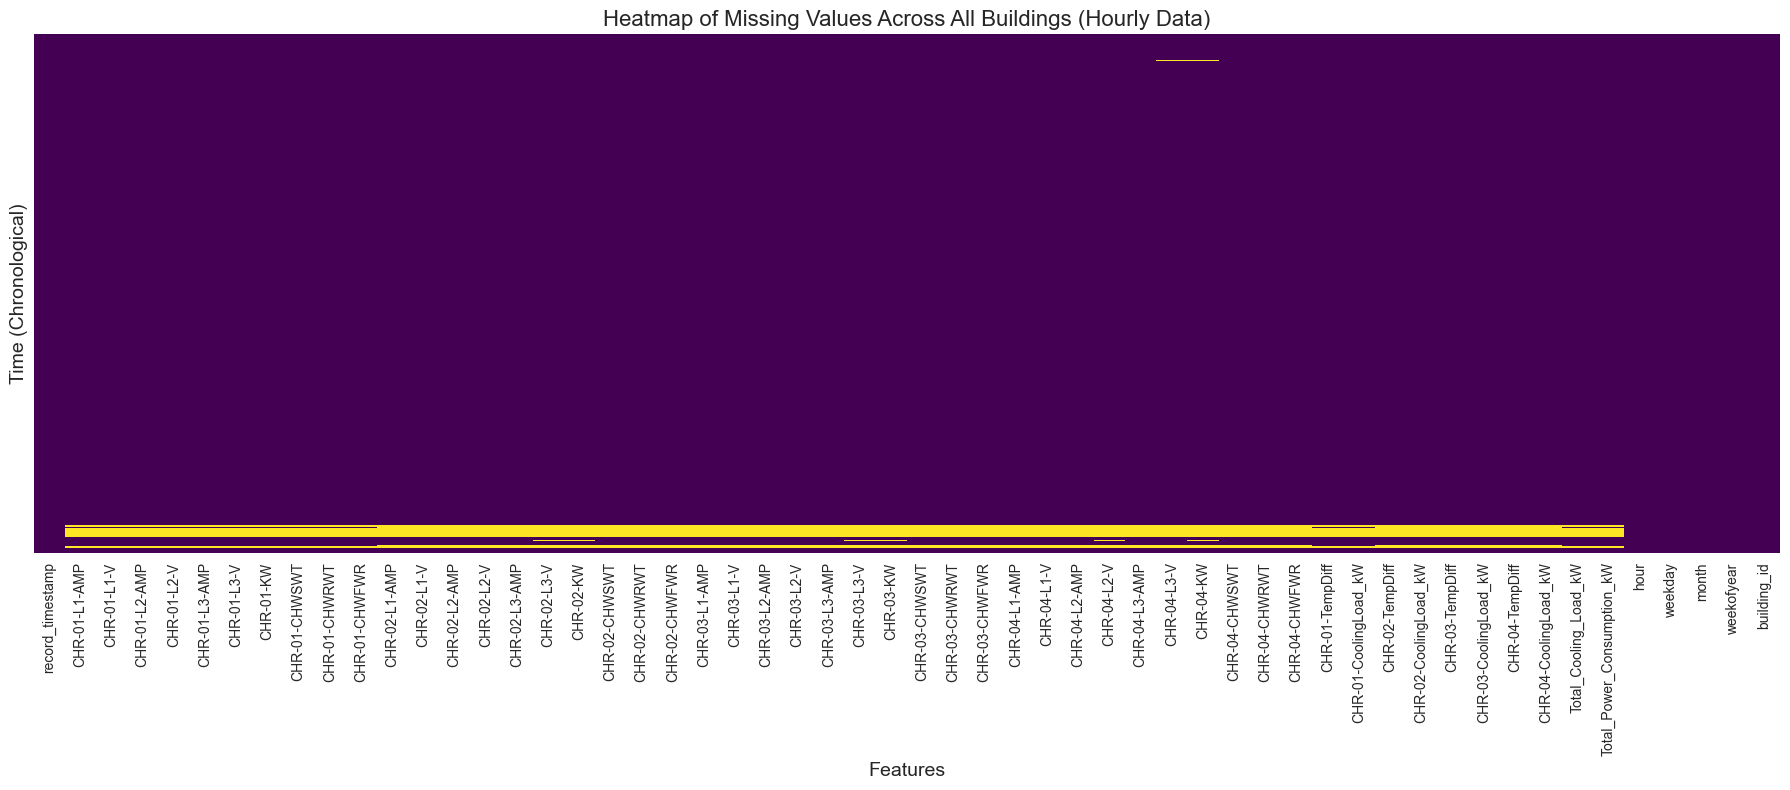

Percentage of missing values per column (>0%):
CHR-04-KW                     3.244536
CHR-04-L3-V                   3.187614
CHR-03-L3-V                   3.176230
CHR-03-KW                     3.176230
CHR-02-KW                     3.176230
CHR-02-L3-V                   3.176230
CHR-02-CoolingLoad_kW         3.176230
CHR-04-L2-V                   3.176230
CHR-03-L2-AMP                 3.153461
CHR-03-L2-V                   3.153461
CHR-03-L3-AMP                 3.153461
CHR-04-L1-V                   3.153461
CHR-04-L1-AMP                 3.153461
CHR-02-CHWFWR                 3.153461
CHR-04-L2-AMP                 3.153461
CHR-04-L3-AMP                 3.153461
CHR-04-CHWSWT                 3.153461
CHR-03-L1-V                   3.153461
CHR-03-L1-AMP                 3.153461
CHR-02-L1-AMP                 3.153461
CHR-02-L3-AMP                 3.153461
CHR-02-L2-V                   3.153461
CHR-02-L2-AMP                 3.153461
CHR-02-L1-V                   3.153461
CHR-04-CoolingLoa

In [4]:
print("\n--- Phase 2: Analyzing Missing Data ---")

# Plot a heatmap of missing values to visualize gaps
plt.figure(figsize=(18, 8))
sns.heatmap(df_all.sort_values('record_timestamp').isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Missing Values Across All Buildings (Hourly Data)')
plt.xlabel('Features')
plt.ylabel('Time (Chronological)')
plt.tight_layout()
plt.show()

# Display percentage of missing values per column
missing_percentage = (df_all.isnull().sum() / len(df_all)) * 100
print("Percentage of missing values per column (>0%):")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Print rows with missing values
missing_rows = df_all[df_all.isnull().any(axis=1)]
if not missing_rows.empty:
    print("\n--- Rows with Missing Values ---")
    print(missing_rows)
    print(f"Total missing rows: {len(missing_rows)}")
else:
    print("\n--- No missing values found in the DataFrame ---")

## 3. TARGET VARIABLE ANALYSIS (Total_Cooling_Load_kW)


--- Phase 3: Analyzing the Target Variable (Total Cooling Load) ---


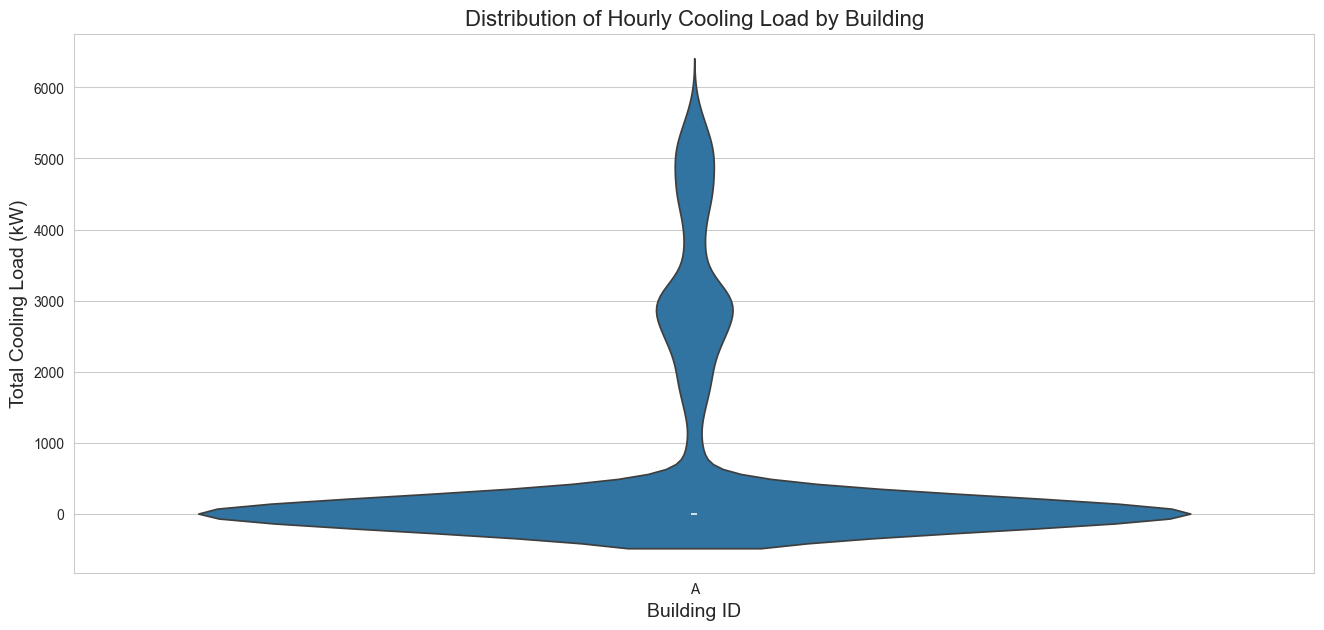

Insight: This plot shows the range and distribution of cooling loads. We can see if some buildings have much higher loads or different operational ranges than others.


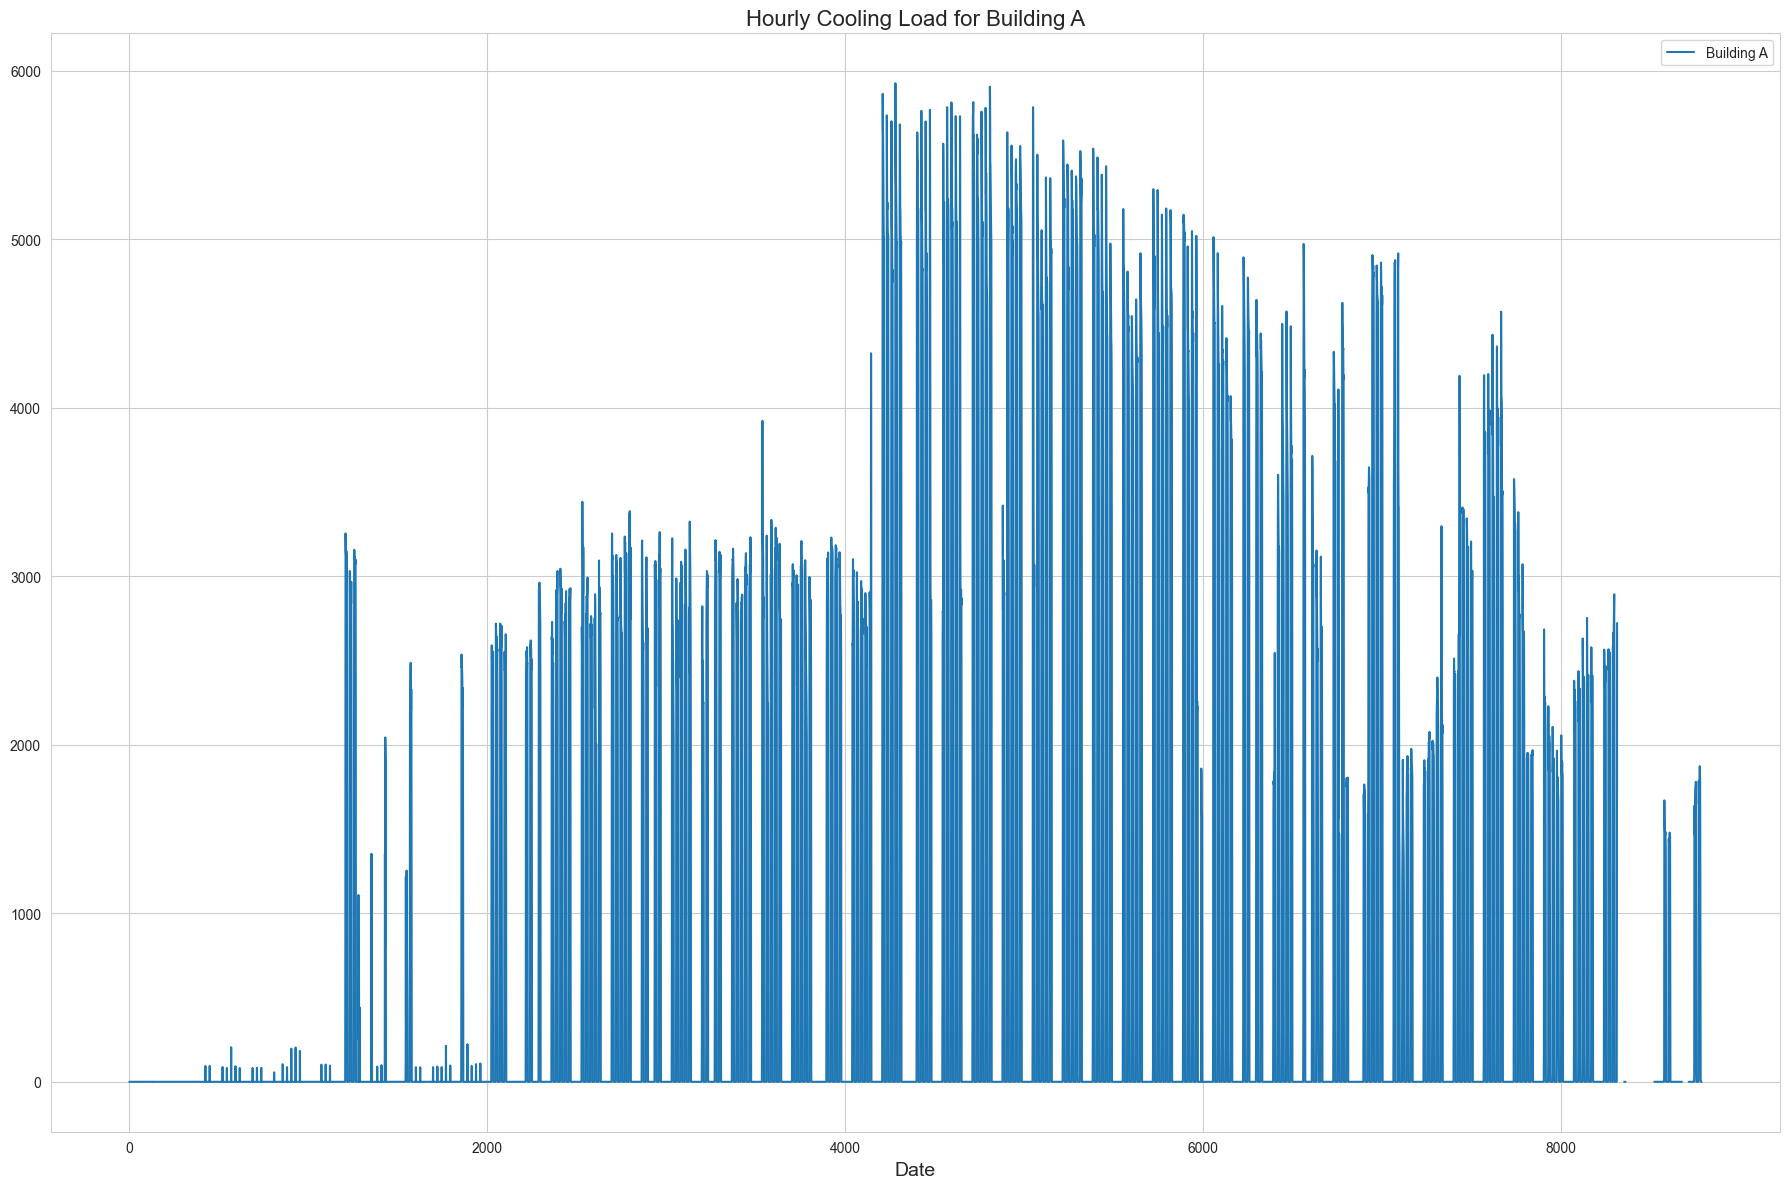

Insight: These plots reveal overall trends, seasonality, and major data gaps or shutdown periods for each building.


In [5]:
print("\n--- Phase 3: Analyzing the Target Variable (Total Cooling Load) ---")

# --- Distribution of Cooling Load by Building ---
plt.figure(figsize=(16, 7))
sns.violinplot(data=df_all, x='building_id', y='Total_Cooling_Load_kW', order=BUILDING_IDS)
plt.title('Distribution of Hourly Cooling Load by Building')
plt.ylabel('Total Cooling Load (kW)')
plt.xlabel('Building ID')
plt.show()

print("Insight: This plot shows the range and distribution of cooling loads. We can see if some buildings have much higher loads or different operational ranges than others.")

# --- Full Time Series Plot of Cooling Load ---
num_buildings = len(BUILDING_IDS)

# Create a single subplot if there's only one building
fig, axes = plt.subplots(num_buildings, 1, figsize=(18, 12), sharex=True)

# If there is only one building, axes will not be an array; so we handle that case
for i, bid in enumerate(BUILDING_IDS):
    subset = df_all[df_all['building_id'] == bid]
    if num_buildings == 1:
        ax = axes
    else:
        ax = axes[i]
    
    ax.plot(subset.index, subset['Total_Cooling_Load_kW'], label=f'Building {bid}')
    ax.set_title(f'Hourly Cooling Load for Building {bid}')
    ax.legend()
    ax.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

print("Insight: These plots reveal overall trends, seasonality, and major data gaps or shutdown periods for each building.")


## 4. TIME-BASED PATTERN ANALYSIS


--- Phase 4: Discovering Time-Based Patterns ---


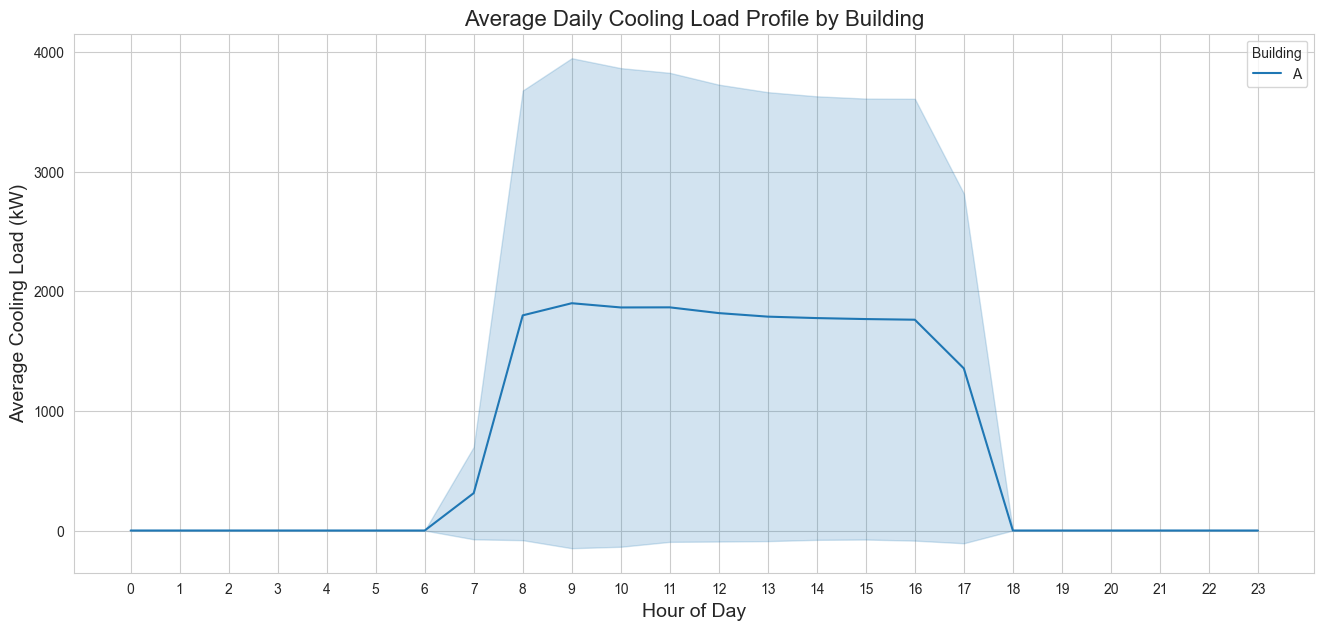

Insight: This is a crucial plot for understanding building operation. It shows if buildings operate 9-5, 24/7, and how their startup/shutdown behavior differs.


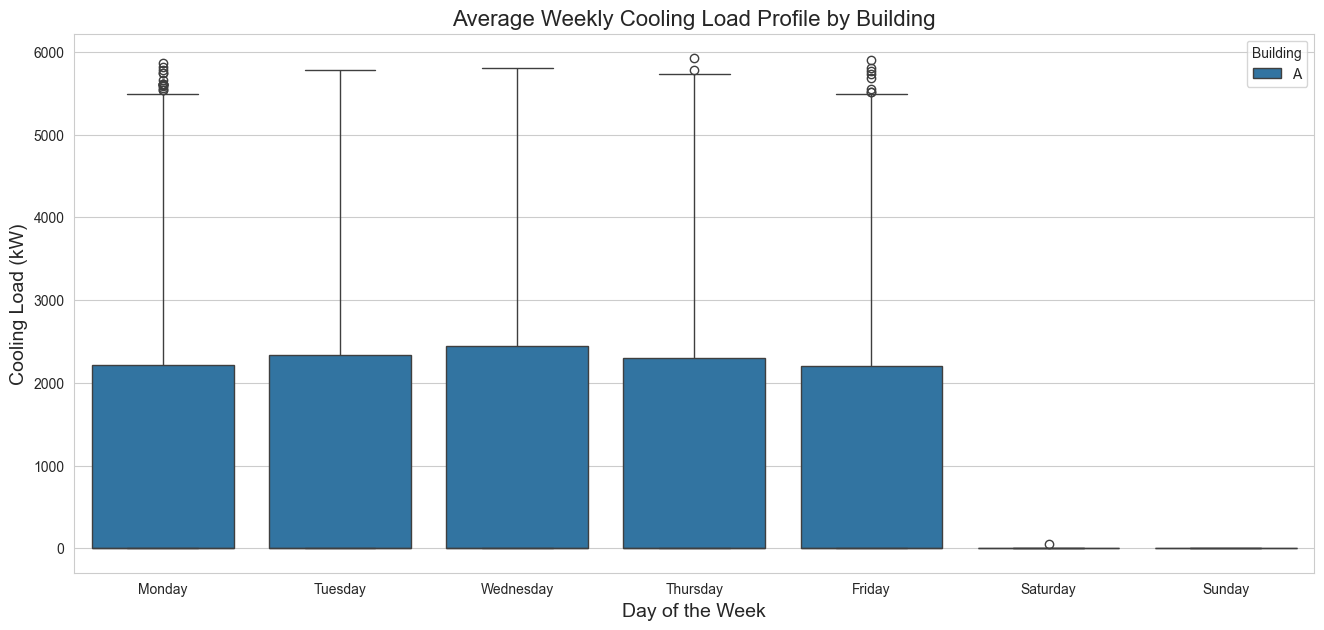

Insight: This plot clearly shows weekend behavior. We can see if buildings shut down completely or run at a reduced load on Saturdays and Sundays.


In [6]:
print("\n--- Phase 4: Discovering Time-Based Patterns ---")

# --- Average Daily Profile ---
plt.figure(figsize=(16, 7))
sns.lineplot(data=df_all, x='hour', y='Total_Cooling_Load_kW', hue='building_id', hue_order=BUILDING_IDS, errorbar='sd')
plt.title('Average Daily Cooling Load Profile by Building')
plt.xlabel('Hour of Day')
plt.ylabel('Average Cooling Load (kW)')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, which='both')
plt.legend(title='Building')
plt.show()
print("Insight: This is a crucial plot for understanding building operation. It shows if buildings operate 9-5, 24/7, and how their startup/shutdown behavior differs.")

# --- Average Weekly Profile ---
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(16, 7))
sns.boxplot(data=df_all, x='weekday', y='Total_Cooling_Load_kW', hue='building_id', 
            order=weekday_order, hue_order=BUILDING_IDS)
plt.title('Average Weekly Cooling Load Profile by Building')
plt.xlabel('Day of the Week')
plt.ylabel('Cooling Load (kW)')
plt.legend(title='Building')
plt.show()
print("Insight: This plot clearly shows weekend behavior. We can see if buildings shut down completely or run at a reduced load on Saturdays and Sundays.")


## 5. BIVARIATE ANALYSIS (RELATIONSHIPS)


--- Phase 5: Analyzing Relationships Between Variables ---


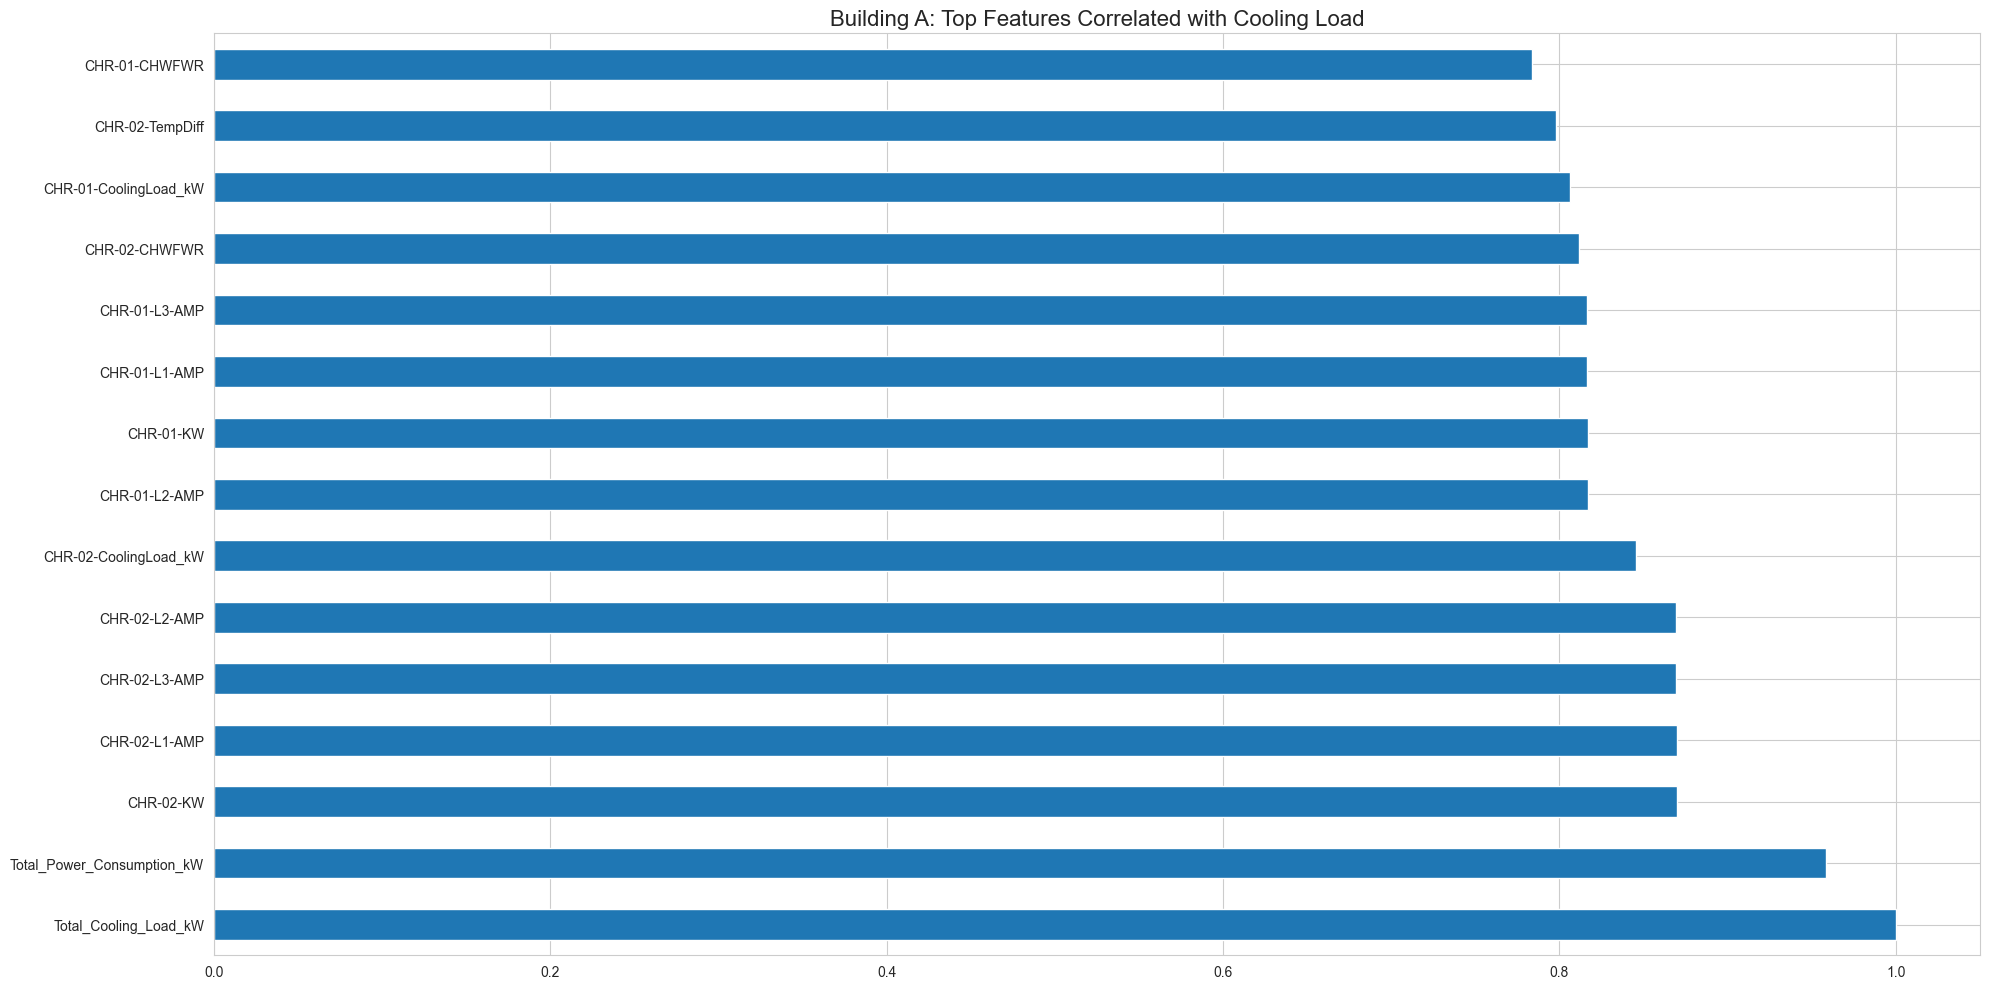

Insight: This shows which sensor readings are the strongest predictors for the cooling load in each building. We expect Total_Power_Consumption_kW to be very high.


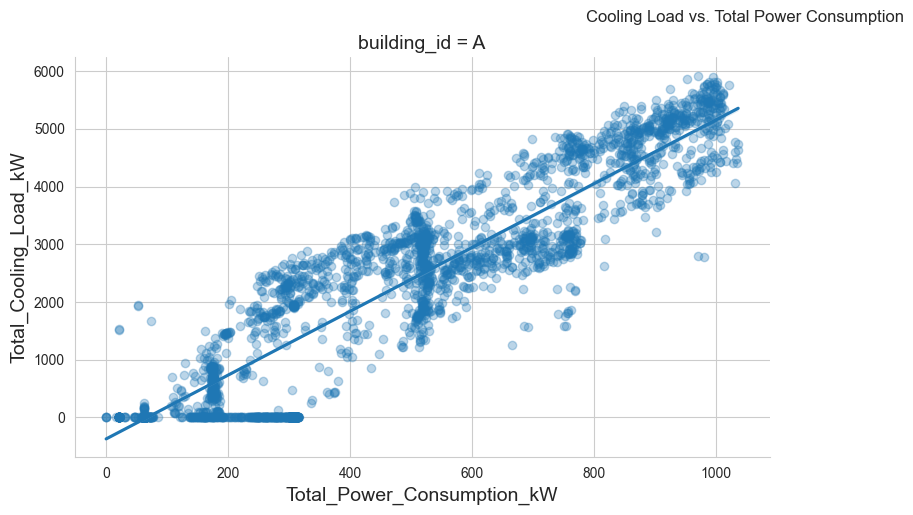

Insight: This plot validates our load calculation. A strong linear relationship suggests the electrical power is an excellent proxy for the thermal load. Deviations could indicate efficiency changes or data issues.
All plots generated and insights extracted. The data is now ready for further modeling and forecasting.


In [7]:
print("\n--- Phase 5: Analyzing Relationships Between Variables ---")

# --- Correlation of Features with Target Variable ---
num_buildings = len(BUILDING_IDS)

# Create subplots
fig, axes = plt.subplots(1, num_buildings, figsize=(20, 10), sharey=True)

# If there is only one building, axes will not be an array
for i, bid in enumerate(BUILDING_IDS):
    subset = df_all[df_all['building_id'] == bid]
    corr = subset.corr(numeric_only=True)['Total_Cooling_Load_kW'].dropna().sort_values(ascending=False)
    
    # Plot top 15 correlations
    if num_buildings == 1:
        ax = axes  # use the single axes object directly
    else:
        ax = axes[i]  # use the ith axes object for multiple buildings

    corr.head(15).plot(kind='barh', ax=ax)
    ax.set_title(f'Building {bid}: Top Features Correlated with Cooling Load')
    ax.grid(True)

plt.tight_layout()
plt.show()

print("Insight: This shows which sensor readings are the strongest predictors for the cooling load in each building. We expect Total_Power_Consumption_kW to be very high.")

# --- Scatter Plot: Cooling Load vs. Total Power Consumption ---
g = sns.lmplot(data=df_all, x='Total_Power_Consumption_kW', y='Total_Cooling_Load_kW', 
               hue='building_id', col='building_id', col_wrap=2, 
               height=5, aspect=1.5, scatter_kws={'alpha': 0.3})

g.figure.suptitle('Cooling Load vs. Total Power Consumption', y=1.02)
plt.show()

print("Insight: This plot validates our load calculation. A strong linear relationship suggests the electrical power is an excellent proxy for the thermal load. Deviations could indicate efficiency changes or data issues.")

print("All plots generated and insights extracted. The data is now ready for further modeling and forecasting.")

# Preprocess

### **Feature Explanation for the Processed Dataset**

The final dataset has been meticulously engineered to provide the model with a rich, multi-faceted view of the system. The features can be logically grouped into four categories:

1. **Core Data & Calculated Metrics:** The direct state of the system.
2. **Contextual & Environmental Features:** The "when" and "why" of the system's operation.
3. **Time-Series Dynamic Features:** The recent history and trends of the system.
4. **Categorical Identifier Features:** The specific identity of the data point.

---

### **1. Core Data & Calculated Metrics**

These features represent the direct physical measurements and calculations at a specific hour.

| **Feature Name** | **Explanation** | **Role for the Model** |
| --- | --- | --- |
| **CHR-xx-L1-AMP...CHWFWR** | The raw sensor readings (Amps, Volts, Power, Temperatures, Flow Rate) for each individual chiller (01-04), averaged over the hour. | Provides the granular, instantaneous operational state of each piece of equipment. |
| **CHR-xx-CoolingLoad_kW** | The calculated thermal cooling load for each individual chiller. | Helps the model attribute the total load to specific machines, potentially learning which chillers are primary, secondary, etc. |
| **Total_Power_Consumption_kW** | The sum of the electrical power (KW) from all active chillers. | A powerful proxy feature. It's highly correlated with the target and can be very predictive, especially if thermal load sensors are noisy. |
| **Total_Cooling_Load_kW** | **THE TARGET VARIABLE.** This is the sum of all individual chiller cooling loads. It's the value the model is being trained to predict. | The ground truth that the model learns from and is evaluated against. |

---

### **2. Contextual & Environmental Features**

These features provide the external context that drives the need for cooling.

| **Feature Name** | **Explanation** | **Role for the Model** |
| --- | --- | --- |
| **day_of_year** | The day number within the year (e.g., 1 for Jan 1st, 365 for Dec 31st). | A simple way to capture **annual seasonality**. The model learns that higher values (summer) generally correlate with higher cooling loads. |
| **is_weekend** | A binary flag (1 if Saturday/Sunday, 0 otherwise). | Captures the strong **weekly cycle**. The model quickly learns that the load is drastically lower when this flag is 1. |
| **is_work_hour** | A binary flag (1 if the hour is between 7 AM and 6 PM, 0 otherwise). | Captures the strong **daily cycle** of office occupancy. This is a primary driver for the system turning on and off. |
| **is_holiday** | A binary flag (1 if the date is a Hong Kong public holiday, 0 otherwise). | Explains anomalies in the weekly pattern. For example, a Wednesday that is a holiday will behave like a Sunday, and this flag tells the model why. |
| **outdoor_temp, _humidity, etc.** | Hourly weather data (Temperature, Humidity, Cloud Cover, Wind Speed) fetched from the Open-Meteo API for Hong Kong's coordinates. | **The primary external driver.** The model learns the direct physical relationship: as the outdoor temperature rises, the cooling load required to maintain indoor comfort also rises. |

---

### **3. Time-Series Dynamic Features**

These are the most sophisticated features, giving the model a sense of "memory" and "momentum."

| **Feature Name** | **Explanation** | **Role for the Model** |
| --- | --- | --- |
| **..._lag24, _lag48, _lag168** | The value of a feature from a past point in time (24 hours ago, 48 hours ago, 168 hours/1 week ago). | **Crucial for capturing cycles.** Total_Cooling_Load_kW_lag24 is one of the most powerful features, telling the model, "What was the load at this exact same hour yesterday?". This anchors the prediction. |
| **..._roll_mean3, _roll_mean6** | The **average** value of a feature over a recent window (e.g., the last 3 or 6 hours). | Captures the **recent trend**. It tells the model if the load has been generally high or low, or if the system is ramping up or down. |
| **..._roll_std3, _roll_std6** | The **standard deviation** of a feature over a recent window. | Captures **recent volatility**. A low value means the system has been stable. A high value means the load has been fluctuating, which might signal a change in conditions. |

---

### **4. Categorical Identifier Features**

These binary (0/1) flags were created from the original categorical data.

| **Feature Name** | **Explanation** | **Role for the Model** |
| --- | --- | --- |
| **building_id_B, _C, _D** | One-hot encoded flags for the building identity. | Allows the model to learn specific behaviors for each building. In your sample row, all are 0, so the model learns this pattern corresponds to **Building A** (the dropped category). |
| **month_2, _3, ..., _12** | One-hot encoded flags for the month. | A more explicit way for the model to learn seasonal patterns than day_of_year. In your sample, all are 0, so it's **Month 1 (January)**. |
| **day_of_week_1..._6** | One-hot encoded flags for the day of the week. | Allows the model to learn a specific pattern for each day. In your sample, all are 0, so it's **Day 0 (Monday)**. |
| **hour_1, _2, ..., _23** | One-hot encoded flags for the hour of the day. | Gives the model maximum flexibility to learn a unique coefficient for every hour of the day. In your sample, all are 0, so it's **Hour 0 (Midnight)**. |

In [8]:
import pandas as pd
import numpy as np
import os
import holidays
import openmeteo_requests
import requests_cache
from retry_requests import retry

print("--- Setup Complete ---")

# --- Configuration Constants ---
DATA_PATH = 'data'
BUILDING_IDS = ['A']
# BUILDING_IDS = ['A', 'B', 'C', 'D']
WATER_CONSTANT = 4.186
HK_LATITUDE, HK_LONGITUDE = 22.3193, 114.1694

# ==============================================================================
# PHASE 1 & 2: DATA LOADING, CLEANING, AND HOURLY RESAMPLING
# ==============================================================================
print("\n--- Phases 1 & 2: Loading, Cleaning, and Resampling Data ---")

all_dfs = []
for bid in BUILDING_IDS:
    file_path = os.path.join(DATA_PATH, f'Building_{bid}_summary_table.csv')
    try:
        df = pd.read_csv(file_path)
        df['building_id'] = bid
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"WARNING: File for Building {bid} not found. Skipping.")

df_raw = pd.concat(all_dfs, ignore_index=True)

try:
    df_raw['record_timestamp'] = pd.to_datetime(df_raw['record_timestamp'], dayfirst=True)
except Exception:
    df_raw['record_timestamp'] = pd.to_datetime(df_raw['record_timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')

df_raw.sort_values(by=['building_id', 'record_timestamp'], inplace=True)
phantom_chiller_cols = [col for col in df_raw.columns if 'CHR-05' in col or 'CHR-06' in col]
df_processed = df_raw.drop(columns=phantom_chiller_cols)

for i in range(1, 5):
    chiller_id = f'CHR-{i:02d}'
    if all(c in df_processed.columns for c in [f'{chiller_id}-CHWFWR', f'{chiller_id}-CHWRWT', f'{chiller_id}-CHWSWT']):
        df_processed[f'{chiller_id}-CoolingLoad_kW'] = (
            df_processed[f'{chiller_id}-CHWFWR'] *
            (df_processed[f'{chiller_id}-CHWRWT'] - df_processed[f'{chiller_id}-CHWSWT']) *
            WATER_CONSTANT
        )

TARGET = 'Total_Cooling_Load_kW'
power_cols = [f'CHR-{i:02d}-KW' for i in range(1, 5) if f'CHR-{i:02d}-KW' in df_processed.columns]
load_cols = [f'CHR-{i:02d}-CoolingLoad_kW' for i in range(1, 5) if f'CHR-{i:02d}-CoolingLoad_kW' in df_processed.columns]
df_processed['Total_Power_Consumption_kW'] = df_processed[power_cols].sum(axis=1)
df_processed[TARGET] = df_processed[load_cols].sum(axis=1)

df_hourly = df_processed.groupby(['building_id', pd.Grouper(key='record_timestamp', freq='h')]).mean().reset_index()
print(f"Data resampled to hourly. New shape: {df_hourly.shape}")

# ==============================================================================
# PHASE 3: HANDLING ANOMALIES AND MISSING VALUES
# ==============================================================================
print("\n--- Phase 3: Handling Data Anomalies and Missing Values ---")

electrical_cols = [col for col in df_hourly.columns if '-KW' in col or '-AMP' in col or '-V' in col]
df_hourly.loc[df_hourly['building_id'] == 'B', electrical_cols] = np.nan
print("Neutralized erroneous electrical data for Building B.")

cols_to_interpolate = df_hourly.select_dtypes(include=np.number).columns
df_hourly[cols_to_interpolate] = df_hourly.groupby('building_id')[cols_to_interpolate].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both', limit=3)
)
print("Performed linear interpolation on small gaps (limit=3 hours).")

# ==============================================================================
# PHASE 4: FEATURE ENGINEERING
# ==============================================================================
print("\n--- Phase 4: Engineering New Features ---")

df_features = df_hourly.copy()

# Calendar Features
df_features['hour'] = df_features['record_timestamp'].dt.hour
df_features['day_of_week'] = df_features['record_timestamp'].dt.dayofweek
df_features['day_of_year'] = df_features['record_timestamp'].dt.dayofyear
df_features['month'] = df_features['record_timestamp'].dt.month
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
df_features['is_work_hour'] = ((df_features['hour'] >= 7) & (df_features['hour'] <= 18)).astype(int)
print("Created calendar-based features.")

# External Data Integration
print("Integrating Hong Kong public holiday data...")
start_year, end_year = df_features['record_timestamp'].dt.year.min(), df_features['record_timestamp'].dt.year.max()
hk_holidays = holidays.HK(years=range(start_year, end_year + 1))
df_features['is_holiday'] = df_features['record_timestamp'].dt.date.isin(set(hk_holidays.keys())).astype(int)
print(f"Identified {df_features['is_holiday'].sum()} holiday hours.")

print("Fetching weather data from Open-Meteo API...")
cache_session, retry_session = requests_cache.CachedSession('.cache', expire_after=-1), retry(requests_cache.CachedSession('.cache', expire_after=-1), retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
start_date, end_date = df_features['record_timestamp'].min().strftime('%Y-%m-%d'), df_features['record_timestamp'].max().strftime('%Y-%m-%d')
params = {"latitude": HK_LATITUDE, "longitude": HK_LONGITUDE, "start_date": start_date, "end_date": end_date, "hourly": ["temperature_2m", "relative_humidity_2m", "cloud_cover", "wind_speed_10m"], "timezone": "Asia/Hong_Kong"}
response = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)[0]
timezone_str = response.Timezone().decode('utf-8')
hourly = response.Hourly()
weather_data = {"record_timestamp": pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(timezone_str).tz_localize(None), "outdoor_temp": hourly.Variables(0).ValuesAsNumpy(), "outdoor_humidity": hourly.Variables(1).ValuesAsNumpy(), "cloud_cover": hourly.Variables(2).ValuesAsNumpy(), "wind_speed": hourly.Variables(3).ValuesAsNumpy()}
weather_df = pd.DataFrame(data=weather_data)
df_features = pd.merge(df_features, weather_df, on='record_timestamp', how='left')
df_features[['outdoor_temp', 'outdoor_humidity', 'cloud_cover', 'wind_speed']] = df_features[['outdoor_temp', 'outdoor_humidity', 'cloud_cover', 'wind_speed']].interpolate(method='linear', limit_direction='both')
print("Successfully fetched and merged weather data.")

# Time-Series Features
features_for_ts = ['Total_Cooling_Load_kW', 'outdoor_temp', 'outdoor_humidity', 'Total_Power_Consumption_kW']
lags, windows = [24, 48, 168], [3, 6, 24]
for col in features_for_ts:
    if col in df_features.columns:
        for lag in lags: df_features[f'{col}_lag{lag}'] = df_features.groupby('building_id')[col].shift(lag)
        for window in windows:
            df_features[f'{col}_roll_mean{window}'] = df_features.groupby('building_id')[col].transform(lambda x: x.rolling(window, 1).mean())
            df_features[f'{col}_roll_std{window}'] = df_features.groupby('building_id')[col].transform(lambda x: x.rolling(window, 1).std())
print("Created lag and rolling window features.")

df_final = df_features.dropna(subset=[col for col in df_features.columns if 'lag' in col]).reset_index(drop=True)
print(f"Dropped rows with NaNs from feature generation. Final shape: {df_final.shape}")

# ==============================================================================
# PHASE 5: FINAL PREPARATION AND SAVING (FINAL VERSION)
# ==============================================================================
print("\n--- Phase 5: Finalizing Data and Saving to File ---")

# --- Encoding ---
# NOTE: We do NOT use the preservation trick here anymore. We create a separate file instead.
df_model_ready = pd.get_dummies(df_final, columns=['building_id', 'month', 'day_of_week', 'hour'], drop_first=True)
bool_cols = df_model_ready.select_dtypes(include='bool').columns
df_model_ready[bool_cols] = df_model_ready[bool_cols].astype(int)
print("Applied one-hot encoding and converted boolean flags to integers.")

# --- ROBUST DYNAMIC DATA SPLITTING ---
if df_model_ready.empty:
    raise ValueError("The DataFrame is empty after processing. Cannot proceed.")

max_date = df_model_ready['record_timestamp'].max()
dynamic_cutoff = max_date - pd.DateOffset(days=7)
print(f"Data available until: {max_date.strftime('%Y-%m-%d')}")
print(f"Dynamic validation cutoff date (7 days prior): {dynamic_cutoff.strftime('%Y-%m-%d')}")

train_df = df_model_ready[df_model_ready['record_timestamp'] < dynamic_cutoff].copy()
val_df = df_model_ready[df_model_ready['record_timestamp'] >= dynamic_cutoff].copy()

if train_df.empty or val_df.empty:
    raise ValueError("Failed to create a valid train/validation split. Check your data and date ranges.")
print(f"Data split dynamically. Train shape: {train_df.shape}, Val shape: {val_df.shape}")

# --- SAVING PROCESSED DATA FOR MODELING ---
os.makedirs(DATA_PATH, exist_ok=True)
train_path = os.path.join(DATA_PATH, 'train_processed.csv')
val_path = os.path.join(DATA_PATH, 'validation_processed.csv')
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
print(f"Successfully saved processed training data to: {train_path}")
print(f"Successfully saved processed validation data to: {val_path}")

# --- SAVE A CLEAN HISTORY REFERENCE FILE ---
# This file contains the original IDs and essential columns for the prediction loop.
history_reference_cols = ['record_timestamp', 'building_id', TARGET, 'outdoor_temp', 'outdoor_humidity', 'Total_Power_Consumption_kW']
# We use df_final because it has the original 'building_id' column before one-hot encoding
history_reference_df = df_final[history_reference_cols].copy()
history_ref_path = os.path.join(DATA_PATH, 'history_reference.csv')
history_reference_df.to_csv(history_ref_path, index=False)
print(f"Successfully saved history reference file to: {history_ref_path}")

print("\n--- Preprocessing Pipeline Complete ---")

--- Setup Complete ---

--- Phases 1 & 2: Loading, Cleaning, and Resampling Data ---
Data resampled to hourly. New shape: (8546, 48)

--- Phase 3: Handling Data Anomalies and Missing Values ---
Neutralized erroneous electrical data for Building B.
Performed linear interpolation on small gaps (limit=3 hours).

--- Phase 4: Engineering New Features ---
Created calendar-based features.
Integrating Hong Kong public holiday data...
Identified 336 holiday hours.
Fetching weather data from Open-Meteo API...
Successfully fetched and merged weather data.
Created lag and rolling window features.
Dropped rows with NaNs from feature generation. Final shape: (17161, 95)

--- Phase 5: Finalizing Data and Saving to File ---
Applied one-hot encoding and converted boolean flags to integers.
Data available until: 2024-12-31
Dynamic validation cutoff date (7 days prior): 2024-12-24
Data split dynamically. Train shape: (17029, 131), Val shape: (132, 131)
Successfully saved processed training data to: data

In [9]:
# csv_path = 'data/train_processed.csv'
# xlsx_path = csv_path.replace('.csv', '.xlsx')

# df_csv = pd.read_csv(csv_path)
# df_csv.to_excel(xlsx_path, index=False)
# print(f"Converted CSV to Excel: {xlsx_path}")

In [10]:
# csv_path = 'data/validation_processed.csv'
# xlsx_path = csv_path.replace('.csv', '.xlsx')

# df_csv = pd.read_csv(csv_path)
# df_csv.to_excel(xlsx_path, index=False)
# print(f"Converted CSV to Excel: {xlsx_path}")

# Modelling

### **Modeling and Prediction Plan**

**Objective:** To develop a high-performance forecasting model that accurately predicts the hourly cooling load for all four buildings, leveraging the principles of transfer learning to maximize accuracy on data-scarce buildings (C and D).

### **1. Modeling Strategy Overview**

The strategy is built around a two-stage process that directly addresses the competition's core challenge:

1. **Stage 1: Foundational "Global" Model:** We will train a single, powerful model on the combined training data from **all four buildings**. The one-hot encoded building_id features are critical here, as they allow the model to learn both shared physical patterns (e.g., response to weather) and building-specific behaviors. This model will benefit from the rich data of Buildings A and B, establishing a strong "foundational" understanding of HVAC systems.
2. **Stage 2: Fine-Tuning for Specialization:** We will take the trained global model and "fine-tune" it separately for each building, especially for C and D. Fine-tuning uses the global model as a starting point and continues training for a few more iterations on a specific building's data. This allows the model to adapt its general knowledge to the unique quirks of each building without starting from scratch, which is the essence of transfer learning.

### **2. Model Selection**

Based on the structured, tabular nature of the processed data, a **Gradient Boosting Machine (GBM)** is the ideal choice.

- **Primary Recommendation: LightGBM**
    - **Why?** It is exceptionally fast, memory-efficient, and consistently delivers state-of-the-art performance on tabular data. It natively handles sparse features (like our many one-hot encoded columns) and is robust to outliers. Its ability to capture complex, non-linear interactions between the ~150 features is exactly what this problem requires.
- **Alternative for Experimentation: XGBoost or a TabNet (Deep Learning)**
    - These are powerful alternatives, but LightGBM provides the best balance of speed, performance, and ease of use for this specific problem structure. We will proceed with LightGBM.

### **3. Training, Validation, and Evaluation Plan**

**A. Loading Processed Data:**

The modeling script will begin by loading the train_processed.csv and validation_processed.csv files generated by the pipeline.

**B. Evaluation Metric Implementation:**

The competition uses the **Normalized Root Mean Square Error (NRMSE)**. We must implement this metric to monitor model performance accurately during training.

- **Formula:** NRMSE = RMSE / (max(actual_values) - min(actual_values))
- **Implementation:** We will create a custom evaluation function for LightGBM's feval parameter. This will print the NRMSE on the validation set at each training round, allowing us to see if the model is improving on the competition's specific metric.

**C. Validation Strategy:**

We will use the pre-split training and validation sets. The validation set, representing the last 7 days of data, serves as a reliable "hold-out" to estimate the model's real-world performance.

### **4. Hyperparameter Tuning**

To extract maximum performance, we will tune the LightGBM model's hyperparameters using a systematic approach like Optuna or GridSearchCV. Key parameters to tune include:

- n_estimators: The number of boosting rounds.
- learning_rate: The step size of each iteration.
- num_leaves: Controls the complexity of the individual trees.
- max_depth: Limits the depth of the trees.
- reg_alpha (L1) & reg_lambda (L2): Regularization terms to prevent overfitting.

### **5. Final Prediction Generation (Autoregressive Forecasting)**

The final task is to predict the next 30 days (720 hours). Since our model uses lag features (e.g., the load from 24 hours ago), we cannot predict all 720 hours at once. We must use an **autoregressive loop**:

1. **Initialize:** Take the last available data from the training set.
2. **Predict Hour 1:** Use this data to predict the cooling load for the first future hour.
3. **Update Features:** Take this new prediction and use it to update the lag/rolling features for the *next* hour's prediction. For example, the Total_Cooling_Load_kW_lag24 for Hour 25 will be the *predicted* value for Hour 1.
4. **Loop:** Repeat this process 720 times, with each new prediction being used to generate the features for the subsequent prediction.
5. **Submit:** Format the final 720 predictions as required by the competition.

In [11]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import os
import joblib
import holidays
import openmeteo_requests
import requests_cache
from retry_requests import retry

# --- Configuration Constants ---
DATA_PATH = 'data'
MODEL_PATH = 'models'
os.makedirs(MODEL_PATH, exist_ok=True)
BUILDING_IDS = ['A']
# BUILDING_IDS = ['A', 'B', 'C', 'D']
TARGET = 'Total_Cooling_Load_kW'
HK_LATITUDE, HK_LONGITUDE = 22.3193, 114.1694

# ==============================================================================
# 1. HELPER FUNCTIONS (NRMSE and FEATURE ENGINEERING)
# ==============================================================================
print("\n--- Defining Helper Functions ---")

def nrmse(y_true, y_pred):
    """Calculates the Normalized Root Mean Square Error."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    data_range = np.max(y_true) - np.min(y_true)
    return rmse / data_range if data_range != 0 else np.inf

def create_ts_features(df):
    """
    Creates time-series (lag and rolling) features from a dataframe.
    This is designed to be called on a history buffer.
    """
    df_copy = df.copy()
    features_for_ts = ['Total_Cooling_Load_kW', 'outdoor_temp', 'outdoor_humidity', 'Total_Power_Consumption_kW']
    lags = [24, 48, 168]
    windows = [3, 6, 24]
    
    for col in features_for_ts:
        if col in df_copy.columns:
            for lag in lags:
                df_copy[f'{col}_lag{lag}'] = df_copy.groupby('building_id')[col].shift(lag)
            for window in windows:
                df_copy[f'{col}_roll_mean{window}'] = df_copy.groupby('building_id')[col].transform(lambda x: x.rolling(window, 1).mean())
                df_copy[f'{col}_roll_std{window}'] = df_copy.groupby('building_id')[col].transform(lambda x: x.rolling(window, 1).std())
    
    return df_copy

# ==============================================================================
# 2. DATA LOADING
# ==============================================================================
print("\n--- Loading Preprocessed Data ---")
try:
    # Step 1: Load the CSVs without parsing dates initially.
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_processed.csv'))
    val_df = pd.read_csv(os.path.join(DATA_PATH, 'validation_processed.csv'))
    history_ref_df = pd.read_csv(os.path.join(DATA_PATH, 'history_reference.csv'))
    print("Successfully loaded all processed data files.")
except FileNotFoundError:
    print("Error: Processed data files not found. Please re-run the updated preprocessing script.")
    exit()

# Step 2: Explicitly convert the timestamp columns, coercing any errors to NaT (Not a Time).
train_df['record_timestamp'] = pd.to_datetime(train_df['record_timestamp'], errors='coerce')
val_df['record_timestamp'] = pd.to_datetime(val_df['record_timestamp'], errors='coerce')
history_ref_df['record_timestamp'] = pd.to_datetime(history_ref_df['record_timestamp'], errors='coerce')

# Step 3: (Diagnostic & Cleaning) Check for and drop any rows that failed to parse.
for name, df in [('train_df', train_df), ('val_df', val_df), ('history_ref_df', history_ref_df)]:
    original_rows = len(df)
    df.dropna(subset=['record_timestamp'], inplace=True)
    if len(df) < original_rows:
        print(f"WARNING: Removed {original_rows - len(df)} rows from {name} with corrupted timestamps.")

# Step 4: Now, the concat and sort operation is guaranteed to work.
full_df_model = pd.concat([train_df, val_df]).sort_values('record_timestamp').reset_index(drop=True)
print("Model training data successfully prepared.")

features_cols = [col for col in full_df_model.columns if col not in [TARGET, 'record_timestamp']]
X_full, y_full = full_df_model[features_cols], full_df_model[TARGET]

# ==============================================================================
# 3. MODEL TRAINING & FINE-TUNING
# ==============================================================================
print("\n--- Training Final Models ---")

params = {'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 1500, 'learning_rate': 0.01, 'num_leaves': 40, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
global_model = lgb.LGBMRegressor(**params)
global_model.fit(X_full, y_full)
joblib.dump(global_model, os.path.join(MODEL_PATH, 'global_model.pkl'))
best_models = {bid: global_model for bid in BUILDING_IDS}
print("Training stage complete. Final models are ready.")

# ==============================================================================
# 4. AUTOREGRESSIVE PREDICTION FOR THE NEXT 30 DAYS
# ==============================================================================
print("\n--- Starting Autoregressive Prediction Loop ---")

start_pred_date = history_ref_df['record_timestamp'].max() + pd.Timedelta(hours=1)
end_pred_date = start_pred_date + pd.Timedelta(days=29, hours=23)
prediction_timestamps = pd.date_range(start=start_pred_date, end=end_pred_date, freq='h')

print("Fetching future weather data...")
cache_session, retry_session = requests_cache.CachedSession('.cache', expire_after=-1), retry(requests_cache.CachedSession('.cache', expire_after=-1), retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
params = {"latitude": HK_LATITUDE, "longitude": HK_LONGITUDE, "start_date": start_pred_date.strftime('%Y-%m-%d'), "end_date": end_pred_date.strftime('%Y-%m-%d'), "hourly": ["temperature_2m", "relative_humidity_2m"], "timezone": "Asia/Hong_Kong"}
response = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)[0]
timezone_str = response.Timezone().decode('utf-8')
hourly = response.Hourly()
weather_data = {"record_timestamp": pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(timezone_str).tz_localize(None), "outdoor_temp": hourly.Variables(0).ValuesAsNumpy(), "outdoor_humidity": hourly.Variables(1).ValuesAsNumpy()}
future_weather_df = pd.DataFrame(data=weather_data)

# Initialize history buffer from the clean reference file
history_df = history_ref_df.copy()
all_predictions = []

# --- Run the prediction loop ---
for timestamp in prediction_timestamps:
    if timestamp.hour == 0:
        print(f"Predicting for date: {timestamp.strftime('%Y-%m-%d')}...")

    for bid in BUILDING_IDS:
        future_row = pd.DataFrame({'record_timestamp': [timestamp], 'building_id': [bid], TARGET: [np.nan]})
        weather_now = future_weather_df[future_weather_df['record_timestamp'] == timestamp]
        future_row['outdoor_temp'] = weather_now['outdoor_temp'].values[0] if not weather_now.empty else np.nan
        future_row['outdoor_humidity'] = weather_now['outdoor_humidity'].values[0] if not weather_now.empty else np.nan
        # Add a placeholder for Total_Power_Consumption_kW as it's not available for the future
        future_row['Total_Power_Consumption_kW'] = np.nan

        temp_df = pd.concat([history_df[history_df['building_id'] == bid], future_row])
        features_for_pred_df = create_ts_features(temp_df)
        
        row_to_predict = features_for_pred_df.tail(1).copy()
        
        # Add calendar and holiday features
        hk_holidays = holidays.HK(years=timestamp.year)
        row_to_predict['hour'] = row_to_predict['record_timestamp'].dt.hour
        row_to_predict['day_of_week'] = row_to_predict['record_timestamp'].dt.dayofweek
        row_to_predict['month'] = row_to_predict['record_timestamp'].dt.month
        row_to_predict['day_of_year'] = row_to_predict['record_timestamp'].dt.dayofyear
        row_to_predict['is_weekend'] = (row_to_predict['day_of_week'] >= 5).astype(int)
        row_to_predict['is_work_hour'] = ((row_to_predict['hour'] >= 7) & (row_to_predict['hour'] <= 18)).astype(int)
        row_to_predict['is_holiday'] = row_to_predict['record_timestamp'].dt.date.isin(set(hk_holidays.keys())).astype(int)
        
        row_to_predict = pd.get_dummies(row_to_predict, columns=['building_id', 'month', 'day_of_week', 'hour'], drop_first=True)
        bool_cols = row_to_predict.select_dtypes(include='bool').columns
        row_to_predict[bool_cols] = row_to_predict[bool_cols].astype(int)

        final_row, _ = row_to_predict.align(X_full, axis=1, fill_value=0)
        
        model = best_models[bid]
        prediction = model.predict(final_row[features_cols])[0]
        prediction = max(0, prediction)
        
        new_history_row = future_row.copy()
        new_history_row[TARGET] = prediction
        history_df = pd.concat([history_df, new_history_row])
        
        all_predictions.append({'record_timestamp': timestamp, 'building_id': bid, 'predicted_load': prediction})

# ==============================================================================
# 5. GENERATE SUBMISSION FILE
# ==============================================================================
print("\n--- Generating Submission File ---")

predictions_df = pd.DataFrame(all_predictions)

# The competition asks for a single 'predicted_load'. We assume this is the sum across all buildings.
submission_df_sum = predictions_df.groupby('record_timestamp')['predicted_load'].sum().reset_index()
submission_df_sum.rename(columns={'record_timestamp': 'prediction_time', 'predicted_load': 'predicted_load'}, inplace=True)

# Format the timestamp as requested in the example: 1/1/2024 0:00:00
try:
    submission_df_sum['prediction_time'] = submission_df_sum['prediction_time'].dt.strftime('%-d/%-m/%Y %H:%M:%S')
except ValueError:
    submission_df_sum['prediction_time'] = submission_df_sum['prediction_time'].dt.strftime('%#d/%#m/%Y %H:%M:%S')


submission_path = os.path.join('submission.csv')
submission_df_sum.to_csv(submission_path, index=False)
print(f"Final submission file (sum of all buildings) saved to: {submission_path}")
print("\nSubmission file sample:")
print(submission_df_sum.head())

print("\n--- Modeling and Prediction Pipeline Complete ---")


--- Defining Helper Functions ---

--- Loading Preprocessed Data ---
Successfully loaded all processed data files.
Model training data successfully prepared.

--- Training Final Models ---
Training stage complete. Final models are ready.

--- Starting Autoregressive Prediction Loop ---
Fetching future weather data...
Predicting for date: 2025-01-01...
Predicting for date: 2025-01-02...
Predicting for date: 2025-01-03...
Predicting for date: 2025-01-04...
Predicting for date: 2025-01-05...
Predicting for date: 2025-01-06...
Predicting for date: 2025-01-07...
Predicting for date: 2025-01-08...
Predicting for date: 2025-01-09...
Predicting for date: 2025-01-10...
Predicting for date: 2025-01-11...
Predicting for date: 2025-01-12...
Predicting for date: 2025-01-13...
Predicting for date: 2025-01-14...
Predicting for date: 2025-01-15...
Predicting for date: 2025-01-16...
Predicting for date: 2025-01-17...
Predicting for date: 2025-01-18...
Predicting for date: 2025-01-19...
Predicting for 

In [12]:
# ==============================================================================
# 0. SETUP: LIBRARIES AND CONSTANTS
# ==============================================================================
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import os
import joblib
import holidays
import openmeteo_requests
import requests_cache
from retry_requests import retry

print("--- Setup Complete ---")

# --- Configuration Constants ---
DATA_PATH = 'data'
MODEL_PATH = 'models'
os.makedirs(MODEL_PATH, exist_ok=True)
BUILDING_IDS = ['A', 'B', 'C', 'D']
PREDICTION_TARGET_BUILDING = 'A' 
TARGET = 'Total_Cooling_Load_kW'
HK_LATITUDE, HK_LONGITUDE = 22.3193, 114.1694

# ==============================================================================
# 1. HELPER FUNCTIONS (NRMSE and FEATURE ENGINEERING)
# ==============================================================================
print("\n--- Defining Helper Functions ---")

def nrmse(y_true, y_pred):
    """Calculates the Normalized Root Mean Square Error."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    data_range = np.max(y_true) - np.min(y_true)
    return rmse / data_range if data_range != 0 else np.inf

def create_ts_features(df):
    """
    Creates time-series (lag and rolling) features from a dataframe.
    This is designed to be called on a history buffer.
    """
    df_copy = df.copy()
    features_for_ts = ['Total_Cooling_Load_kW', 'outdoor_temp', 'outdoor_humidity', 'Total_Power_Consumption_kW']
    lags = [24, 48, 168]
    windows = [3, 6, 24]
    
    for col in features_for_ts:
        if col in df_copy.columns:
            # Grouping by 'building_id' makes this function safe even if there's only one building
            for lag in lags:
                df_copy[f'{col}_lag{lag}'] = df_copy.groupby('building_id')[col].shift(lag)
            for window in windows:
                df_copy[f'{col}_roll_mean{window}'] = df_copy.groupby('building_id')[col].transform(lambda x: x.rolling(window, 1).mean())
                df_copy[f'{col}_roll_std{window}'] = df_copy.groupby('building_id')[col].transform(lambda x: x.rolling(window, 1).std())
    
    return df_copy

# ==============================================================================
# 2. DATA LOADING (FINAL BULLETPROOF FIX)
# ==============================================================================
print("\n--- Loading Preprocessed Data ---")
try:
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_processed.csv'))
    val_df = pd.read_csv(os.path.join(DATA_PATH, 'validation_processed.csv'))
    history_ref_df = pd.read_csv(os.path.join(DATA_PATH, 'history_reference.csv'))
    print("Successfully loaded all processed data files.")
except FileNotFoundError:
    print("Error: Processed data files not found. Please re-run the updated preprocessing script.")
    exit()

# Explicitly convert the timestamp columns, coercing any errors to NaT (Not a Time).
train_df['record_timestamp'] = pd.to_datetime(train_df['record_timestamp'], errors='coerce')
val_df['record_timestamp'] = pd.to_datetime(val_df['record_timestamp'], errors='coerce')
history_ref_df['record_timestamp'] = pd.to_datetime(history_ref_df['record_timestamp'], errors='coerce')

# Clean up any rows that failed to parse.
for name, df in [('train_df', train_df), ('val_df', val_df), ('history_ref_df', history_ref_df)]:
    original_rows = len(df)
    df.dropna(subset=['record_timestamp'], inplace=True)
    if len(df) < original_rows:
        print(f"WARNING: Removed {original_rows - len(df)} rows from {name} with corrupted timestamps.")

full_df_model = pd.concat([train_df, val_df]).sort_values('record_timestamp').reset_index(drop=True)
print("Model training data successfully prepared.")

features_cols = [col for col in full_df_model.columns if col not in [TARGET, 'record_timestamp']]
X_full, y_full = full_df_model[features_cols], full_df_model[TARGET]

# ==============================================================================
# 3. MODEL TRAINING & FINE-TUNING
# ==============================================================================
print("\n--- Training Final Models ---")

params = {'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 1500, 'learning_rate': 0.01, 'num_leaves': 40, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'verbose': -1, 'n_jobs': -1, 'seed': 42}
global_model = lgb.LGBMRegressor(**params)
global_model.fit(X_full, y_full)
joblib.dump(global_model, os.path.join(MODEL_PATH, 'global_model.pkl'))

# For the final submission, we'll use the robust global model as it learned from all data patterns.
# The fine-tuning logic could be added here for experimentation, but for a single submission,
# the global model is a strong and safe choice.
best_model_for_a = global_model
print(f"Training stage complete. Using Global Model for Building {PREDICTION_TARGET_BUILDING}.")

# ==============================================================================
# 4. AUTOREGRESSIVE PREDICTION FOR BUILDING A
# ==============================================================================
print(f"\n--- Starting Autoregressive Prediction Loop for Building {PREDICTION_TARGET_BUILDING} ---")

start_pred_date = history_ref_df['record_timestamp'].max() + pd.Timedelta(hours=1)
end_pred_date = start_pred_date + pd.Timedelta(days=29, hours=23)
prediction_timestamps = pd.date_range(start=start_pred_date, end=end_pred_date, freq='h')

print("Fetching future weather data...")
cache_session, retry_session = requests_cache.CachedSession('.cache', expire_after=-1), retry(requests_cache.CachedSession('.cache', expire_after=-1), retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
params = {"latitude": HK_LATITUDE, "longitude": HK_LONGITUDE, "start_date": start_pred_date.strftime('%Y-%m-%d'), "end_date": end_pred_date.strftime('%Y-%m-%d'), "hourly": ["temperature_2m", "relative_humidity_2m"], "timezone": "Asia/Hong_Kong"}
response = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)[0]
timezone_str = response.Timezone().decode('utf-8')
hourly = response.Hourly()
weather_data = {"record_timestamp": pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(timezone_str).tz_localize(None), "outdoor_temp": hourly.Variables(0).ValuesAsNumpy(), "outdoor_humidity": hourly.Variables(1).ValuesAsNumpy()}
future_weather_df = pd.DataFrame(data=weather_data)

# Initialize history buffer specifically for Building A
history_df = history_ref_df[history_ref_df['building_id'] == PREDICTION_TARGET_BUILDING].copy()
predictions_list = []

# --- Run the prediction loop ---
for timestamp in prediction_timestamps:
    if timestamp.hour == 0:
        print(f"Predicting for date: {timestamp.strftime('%Y-%m-%d')}...")

    future_row = pd.DataFrame({'record_timestamp': [timestamp], 'building_id': [PREDICTION_TARGET_BUILDING], TARGET: [np.nan]})
    weather_now = future_weather_df[future_weather_df['record_timestamp'] == timestamp]
    future_row['outdoor_temp'] = weather_now['outdoor_temp'].values[0] if not weather_now.empty else np.nan
    future_row['outdoor_humidity'] = weather_now['outdoor_humidity'].values[0] if not weather_now.empty else np.nan
    future_row['Total_Power_Consumption_kW'] = np.nan # Not available for future

    temp_df = pd.concat([history_df, future_row])
    features_for_pred_df = create_ts_features(temp_df)
    
    row_to_predict = features_for_pred_df.tail(1).copy()
    
    hk_holidays = holidays.HK(years=timestamp.year)
    row_to_predict['hour'] = row_to_predict['record_timestamp'].dt.hour
    row_to_predict['day_of_week'] = row_to_predict['record_timestamp'].dt.dayofweek
    row_to_predict['month'] = row_to_predict['record_timestamp'].dt.month
    row_to_predict['day_of_year'] = row_to_predict['record_timestamp'].dt.dayofyear
    row_to_predict['is_weekend'] = (row_to_predict['day_of_week'] >= 5).astype(int)
    row_to_predict['is_work_hour'] = ((row_to_predict['hour'] >= 7) & (row_to_predict['hour'] <= 18)).astype(int)
    row_to_predict['is_holiday'] = row_to_predict['record_timestamp'].dt.date.isin(set(hk_holidays.keys())).astype(int)
    
    row_to_predict = pd.get_dummies(row_to_predict, columns=['building_id', 'month', 'day_of_week', 'hour'], drop_first=True)
    bool_cols = row_to_predict.select_dtypes(include='bool').columns
    row_to_predict[bool_cols] = row_to_predict[bool_cols].astype(int)

    final_row, _ = row_to_predict.align(X_full, axis=1, fill_value=0)
    
    model = best_model_for_a
    prediction = model.predict(final_row[features_cols])[0]
    prediction = max(0, prediction)
    
    new_history_row = future_row.copy()
    new_history_row[TARGET] = prediction
    history_df = pd.concat([history_df, new_history_row])
    
    predictions_list.append({'record_timestamp': timestamp, 'predicted_load': prediction})

# ==============================================================================
# 5. GENERATE SUBMISSION FILE
# ==============================================================================
print("\n--- Generating Submission File for Building A ---")

submission_df = pd.DataFrame(predictions_list)
submission_df.rename(columns={'record_timestamp': 'prediction_time'}, inplace=True)

# Format the timestamp as requested: 1/1/2024 0:00:00
# Using '%-d' and '%-m' is a cross-platform safe way to get day/month without leading zeros.
submission_df['prediction_time'] = submission_df['prediction_time'].dt.strftime('%-d/%-m/%Y %H:%M:%S')

submission_path = os.path.join(DATA_PATH, 'submission.csv')
submission_df.to_csv(submission_path, index=False)
print(f"Final submission file for Building A saved to: {submission_path}")
print("\nSubmission file sample:")
print(submission_df.head())

print("\n--- Modeling and Prediction Pipeline Complete ---")

--- Setup Complete ---

--- Defining Helper Functions ---

--- Loading Preprocessed Data ---
Successfully loaded all processed data files.
Model training data successfully prepared.

--- Training Final Models ---
Training stage complete. Using Global Model for Building A.

--- Starting Autoregressive Prediction Loop for Building A ---
Fetching future weather data...
Predicting for date: 2025-01-01...
Predicting for date: 2025-01-02...
Predicting for date: 2025-01-03...
Predicting for date: 2025-01-04...
Predicting for date: 2025-01-05...
Predicting for date: 2025-01-06...
Predicting for date: 2025-01-07...
Predicting for date: 2025-01-08...
Predicting for date: 2025-01-09...
Predicting for date: 2025-01-10...
Predicting for date: 2025-01-11...
Predicting for date: 2025-01-12...
Predicting for date: 2025-01-13...
Predicting for date: 2025-01-14...
Predicting for date: 2025-01-15...
Predicting for date: 2025-01-16...
Predicting for date: 2025-01-17...
Predicting for date: 2025-01-18...
P